In [1]:
%cd ~/projects/kaggle/quora
from matplotlib import pyplot as plt
%matplotlib inline

/Users/trung/projects/kaggle/quora


In [2]:
import pandas as pd
import nltk
import numpy as np
from __future__ import print_function, division
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Read data

In [41]:
d = pd.read_csv('data/raw/train.csv')
dt = pd.read_csv('data/raw/test.csv')
d['question1'].fillna('', inplace=True)
d['question1'] = d['question1'].map(lambda x: x.replace(' ?', '?'))
d['question2'].fillna('', inplace=True)
d['question2'] = d['question2'].map(lambda x: x.replace(' ?', '?'))
dt['question1'].fillna('', inplace=True)
dt['question1'] = dt['question1'].map(lambda x: x.replace(' ?', '?'))
dt['question2'].fillna('', inplace=True)
dt['question2'] = dt['question2'].map(lambda x: x.replace(' ?', '?'))

In [6]:
d.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
dt.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


## Feature: Are sentences of same question type?

In [42]:
def first_word(s):
    return s.split(' ')[0]

In [43]:
t1 = d['question1'].apply(first_word)
t2 = d['question2'].apply(first_word)
d['same_qtype'] = np.equal(t1, t2).astype(int)
dt['same_qtype'] = np.equal(dt['question1'].apply(first_word), dt['question2'].apply(first_word)).astype(int)

In [6]:
pd.crosstab(d.same_qtype, d.is_duplicate)

is_duplicate,0,1
same_qtype,,
0,148279,56281
1,106748,92982


What are some example of not same question type but is still duplicate?

In [43]:
tmp = d[np.logical_and(d.same_qtype == 0, d.is_duplicate == 1)]

In [48]:
tmp.head(10)

,id,qid1,qid2,question1,question2,is_duplicate,same_qtype
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,False
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,False
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1,False
15,15,31,32,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...,1,False
31,31,63,64,What are some special cares for someone with a...,How can I keep my nose from getting stuffy at ...,1,False
50,50,101,102,Is Career Launcher good for RBI Grade B prepar...,How is career launcher online program for RBI ...,1,False
51,51,103,104,Will a Blu Ray play on a regular DVD player? I...,How can you play a Blu Ray DVD on a regular DV...,1,False
65,65,131,132,What is Java programming? How To Learn Java Pr...,How do I learn a computer language like java?,1,False
67,67,135,136,Can we ever store energy produced in lightning?,Is it possible to store the energy of lightning?,1,False
73,73,147,148,How helpful is QuickBooks' auto data recovery ...,What is the quickbooks customer support phone ...,1,False


## Feature: Do both questions contain words like 'not', 'can', ' best ', ' most ', ' is ', ' are '?

In [44]:
def contains_word(word, x):
    return word in x

words = [' not ', ' can ', ' do ', ' best ', ' better ', ' most ', ' is ', ' are ']
for word in words:
    print('word: ', word)
    t1 = d['question1'].apply(lambda x: contains_word(word, x))
    t2 = d['question2'].apply(lambda x: contains_word(word, x))
    fname = 'have_' + word.strip()
    d[fname] = np.equal(t1, t2).astype(int)
    t1 = dt['question1'].apply(lambda x: contains_word(word, x))
    t2 = dt['question2'].apply(lambda x: contains_word(word, x))
    dt[fname] = np.equal(t1, t2).astype(int)
    print(np.corrcoef(d[fname], d['is_duplicate']))

word:   not 
[[ 1.          0.06476894]
 [ 0.06476894  1.        ]]
word:   can 
[[ 1.         -0.01358206]
 [-0.01358206  1.        ]]
word:   do 
[[ 1.          0.02279528]
 [ 0.02279528  1.        ]]
word:   best 
[[ 1.         -0.01396001]
 [-0.01396001  1.        ]]
word:   better 
[[ 1.         0.0323126]
 [ 0.0323126  1.       ]]
word:   most 
[[ 1.          0.02066444]
 [ 0.02066444  1.        ]]
word:   is 
[[ 1.          0.07473056]
 [ 0.07473056  1.        ]]
word:   are 
[[ 1.         0.0409897]
 [ 0.0409897  1.       ]]


In [46]:
d.columns, dt.columns

(Index([u'id', u'qid1', u'qid2', u'question1', u'question2', u'is_duplicate',
        u'same_qtype', u'have_not', u'have_can', u'have_do', u'have_best',
        u'have_better', u'have_most', u'have_is', u'have_are'],
       dtype='object'),
 Index([u'test_id', u'question1', u'question2', u'same_qtype', u'have_not',
        u'have_can', u'have_do', u'have_best', u'have_better', u'have_most',
        u'have_is', u'have_are'],
       dtype='object'))

## Output features

In [47]:
d.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1, inplace=True)
d.to_csv('data/processed/train_set4.csv', index=False)
dt.drop(['test_id', 'question1', 'question2'], axis=1, inplace=True)
dt.to_csv('data/processed/test_set4.csv', index=False)

# Ignore question words

We can create another version of data where all question words are ignored.

In [3]:
train.to_csv('data/processed/train.csv', index=False)
test.to_csv('data/processed/test.csv', index=False)

NameError: name 'train' is not defined

In [4]:
train = pd.read_csv('data/processed/train.csv')
test = pd.read_csv('data/processed/test.csv')

In [41]:
dup_columns = ['z_len1', 'z_len2', 'z_word_len1', 'z_word_len2', 'x3', 'x12', 'x21']
train.drop(dup_columns, axis=1, inplace=True)
test.drop(dup_columns, axis=1, inplace=True)

In [42]:
train.columns, test.columns

(Index([u'len_q1', u'len_q2', u'diff_len', u'len_char_q1', u'len_char_q2',
        u'len_word_q1', u'len_word_q2', u'common_words', u'fuzz_qratio',
        u'fuzz_WRatio', u'fuzz_partial_ratio', u'fuzz_partial_token_set_ratio',
        u'fuzz_partial_token_sort_ratio', u'fuzz_token_set_ratio',
        u'fuzz_token_sort_ratio', u'wmd', u'cosine_distance',
        u'cityblock_distance', u'jaccard_distance', u'canberra_distance',
        u'euclidean_distance', u'braycurtis_distance', u'skew_q1vec',
        u'skew_q2vec', u'kur_q1vec', u'kur_q2vec', u'x0', u'x1', u'x2', u'x4',
        u'x5', u'x6', u'x7', u'x8', u'x9', u'x10', u'x11', u'x13', u'x14',
        u'x15', u'x16', u'x17', u'x18', u'x19', u'x20', u'x22', u'x23', u'x24',
        u'x25', u'x26', u'z_match_ratio', u'z_word_match', u'z_tfidf_sum1',
        u'z_tfidf_sum2', u'z_tfidf_mean1', u'z_tfidf_mean2', u'z_tfidf_len1',
        u'z_tfidf_len2'],
       dtype='object'),
 Index([u'len_q1', u'len_q2', u'diff_len', u'len_char_q1', u'

In [48]:
def resample(x, y):
    pos = x[y == 1]
    neg = x[y == 0]

    # Now we oversample the negative class
    # There is likely a much more elegant way to do this...
    p = 0.165
    scale = ((len(pos) / (len(pos) + len(neg))) / p) - 1
    while scale > 1:
        neg = pd.concat([neg, neg])
        scale -=1
    neg = pd.concat([neg, neg[:int(scale * len(neg))]])
    print(len(pos) / (len(pos) + len(neg)))

    x = pd.concat([pos, neg])
    y = np.hstack(((np.ones(len(pos))), np.zeros(len(neg))))
    return x, y

## Over-sample the negative class 

We over-sample the negative class to get same pos / neg ratio as in the test set.

In [56]:
y = d.is_duplicate.values
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=1110)
# this ways of sampling gives us a validation set that does not contain leakage from training set
s_train, s_y = resample(X_train, y_train)

0.191260105603


### Choosing number of trees

In [58]:
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt', # or dart
                           num_leaves=32, # log2(num_leaves) => max_depth in xgboost
                           learning_rate=0.05,
                           n_estimators=4000, # num trees
                           min_child_weight=1,
                           subsample=0.7,
                           colsample_bytree=0.7,
                           seed=1234)
model.fit(s_train, s_y,
          eval_set=[(s_train, s_y), (X_val, y_val)],
          eval_metric='logloss',
          early_stopping_rounds=50
         )

[1]	valid_0's binary_logloss: 0.668833	valid_1's binary_logloss: 0.677798
Train until valid scores didn't improve in 50 rounds.
[2]	valid_0's binary_logloss: 0.646753	valid_1's binary_logloss: 0.664062
[3]	valid_0's binary_logloss: 0.626383	valid_1's binary_logloss: 0.651439
[4]	valid_0's binary_logloss: 0.607806	valid_1's binary_logloss: 0.64006
[5]	valid_0's binary_logloss: 0.590838	valid_1's binary_logloss: 0.629939
[6]	valid_0's binary_logloss: 0.575409	valid_1's binary_logloss: 0.620951
[7]	valid_0's binary_logloss: 0.560981	valid_1's binary_logloss: 0.612523
[8]	valid_0's binary_logloss: 0.547666	valid_1's binary_logloss: 0.604855
[9]	valid_0's binary_logloss: 0.535459	valid_1's binary_logloss: 0.598026
[10]	valid_0's binary_logloss: 0.524182	valid_1's binary_logloss: 0.591838
[11]	valid_0's binary_logloss: 0.513678	valid_1's binary_logloss: 0.586127
[12]	valid_0's binary_logloss: 0.50391	valid_1's binary_logloss: 0.580883
[13]	valid_0's binary_logloss: 0.494864	valid_1's binary_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.7, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.05, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=10, min_child_weight=1,
        min_split_gain=0, n_estimators=4000, nthread=-1, num_leaves=32,
        objective='binary', reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=1234, sigmoid=1.0, silent=True, skip_drop=0.5, subsample=0.7,
        subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False)

### Re-train model on full data set

Now we have to re-sample to get the right pos / neg ratio on the full dataset.

In [59]:
y = d.is_duplicate.values
s_train, s_y = resample(train, y)

0.191243661001


In [60]:
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt', # or dart
                           num_leaves=32, # log2(num_leaves) => max_depth in xgboost
                           learning_rate=0.05,
                           n_estimators=4000, # num trees
                           min_child_weight=1,
                           subsample=0.7,
                           colsample_bytree=0.7,
                           seed=1234)
model.fit(s_train, s_y,
          eval_set=[(s_train, s_y)],
          eval_metric='logloss')

[1]	valid_0's binary_logloss: 0.668888
[2]	valid_0's binary_logloss: 0.646835
[3]	valid_0's binary_logloss: 0.626494
[4]	valid_0's binary_logloss: 0.607931
[5]	valid_0's binary_logloss: 0.590961
[6]	valid_0's binary_logloss: 0.575501
[7]	valid_0's binary_logloss: 0.561092
[8]	valid_0's binary_logloss: 0.547798
[9]	valid_0's binary_logloss: 0.535613
[10]	valid_0's binary_logloss: 0.524359
[11]	valid_0's binary_logloss: 0.513873
[12]	valid_0's binary_logloss: 0.504142
[13]	valid_0's binary_logloss: 0.495091
[14]	valid_0's binary_logloss: 0.486694
[15]	valid_0's binary_logloss: 0.478891
[16]	valid_0's binary_logloss: 0.471664
[17]	valid_0's binary_logloss: 0.46491
[18]	valid_0's binary_logloss: 0.458545
[19]	valid_0's binary_logloss: 0.452669
[20]	valid_0's binary_logloss: 0.447149
[21]	valid_0's binary_logloss: 0.441962
[22]	valid_0's binary_logloss: 0.437114
[23]	valid_0's binary_logloss: 0.43256
[24]	valid_0's binary_logloss: 0.428289
[25]	valid_0's binary_logloss: 0.424228
[26]	valid_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.7, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.05, max_bin=255, max_depth=-1,
        max_drop=50, min_child_samples=10, min_child_weight=1,
        min_split_gain=0, n_estimators=4000, nthread=-1, num_leaves=32,
        objective='binary', reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
        seed=1234, sigmoid=1.0, silent=True, skip_drop=0.5, subsample=0.7,
        subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False)

In [61]:
def write_predictions(model, x_test, location):
    y_pred = model.predict_proba(x_test, num_iteration=model.best_iteration)[:,1]
    print(np.mean(y_pred))
    sub = pd.DataFrame({'test_id': dt.test_id, 'is_duplicate': y_pred})
    sub.to_csv(location, index=False)
    return y_pred

In [62]:
write_predictions(model, test, 'results/trung_final.csv')

0.146670137549


array([ 0.00395316,  0.49275726,  0.48895305, ...,  0.00210012,
        0.1431655 ,  0.18880258])

## Ensemble

TODO: Calibrate the scores:?

http://scikit-learn.org/stable/modules/calibration.html

http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html

### Ensemble my result with StackNet.

- So simple averaging of my model with stacknet gives LB score of 0.30082. This is better than including the output from this https://www.kaggle.com/woters/quora-question-pairs/xgb-starter-12357/output which gives 0.30082.

In [64]:
#y1 = pd.read_csv('results/variant2_3000.csv.gz')
y1 = pd.read_csv('results/trung_final.csv.gz')
y2 = pd.read_csv('results/stacknet.csv', header=None)
y2.columns = ['dummy', 'is_duplicate']
y2.drop('dummy', inplace=True, axis=1)
y2['test_id'] = y1.test_id

In [65]:
y3 = pd.read_csv('results/xgb_seed12357_n315.csv')

In [66]:
y1.shape, y2.shape, y3.shape

((2345796, 2), (2345796, 2), (2345796, 2))

In [67]:
np.mean(y1.is_duplicate), np.mean(y2.is_duplicate), np.mean(y3.is_duplicate)

(0.1466701375488361, 0.2039776797034145, 0.14769750891379135)

In [140]:
y2.is_duplicate.describe()

count    2345796.000000
mean           0.203978
std            0.270430
min            0.000035
25%            0.000844
50%            0.039149
75%            0.369236
max            0.999034
Name: is_duplicate, dtype: float64

In [68]:
y1.is_duplicate.describe()

count    2.345796e+06
mean     1.466701e-01
std      1.864384e-01
min      3.543340e-11
25%      1.768412e-04
50%      4.770856e-02
75%      2.642621e-01
max      9.979974e-01
Name: is_duplicate, dtype: float64

In [138]:
y3.is_duplicate.describe()

count    2.345796e+06
mean     1.476975e-01
std      1.772065e-01
min      6.528065e-07
25%      2.011855e-04
50%      2.808124e-02
75%      3.241177e-01
max      9.887874e-01
Name: is_duplicate, dtype: float64

In [9]:
sub = pd.DataFrame({'is_duplicate': y1.is_duplicate + y2.is_duplicate,
                   'test_id': y1.test_id})
sub.is_duplicate = sub.is_duplicate / 2
sub.to_csv('results/ensemble_.csv', index=False)

In [6]:
sub = pd.read_csv('results/ensemble.csv.gz')

(array([  1.26081000e+06,   1.88119000e+05,   2.12589000e+05,
          2.60619000e+05,   2.30160000e+05,   1.34168000e+05,
          4.42720000e+04,   1.06480000e+04,   3.98800000e+03,
          4.23000000e+02]),
 array([  1.23129367e-05,   9.55572877e-02,   1.91102262e-01,
          2.86647237e-01,   3.82192212e-01,   4.77737187e-01,
          5.73282161e-01,   6.68827136e-01,   7.64372111e-01,
          8.59917086e-01,   9.55462060e-01]),
 <a list of 10 Patch objects>)

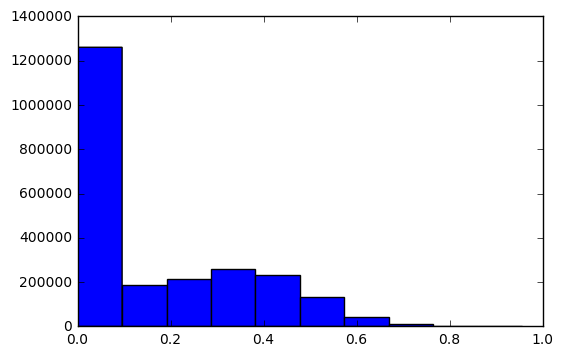

In [7]:
plt.hist(sub.is_duplicate.values)